# Задание 2: Трехклассовая семантическая сегментация

Предлагается решить задачу семантической сегментации животных с тремя классами: класс "фон" (метка 0), класс "кошка" (метка 1) и класс "собака" (метка 2).
![Image](https://miro.medium.com/max/1130/1*DDEkOFC93pEbrTdyhdpXZg.png)

Для этого сами подготовим [датасет](https://drive.google.com/uc?export=download&id=1ZsRAXiPgOU5Am8tNZ7mruwtJh3ck8TI5), реализуем метрики/функции потерь, реализуем и обучим свою [PSPNet](https://arxiv.org/abs/1612.01105)-подобную архитектуру.

In [8]:
# скачиваем данные
!unzip -qq data.zip

replace SegTask/trainval.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Загрузка модулей

In [4]:
# Загружаем pytorch для работы с нейронными сетями
import torch
import torch.nn as nn
import torch.nn.functional as F

# Для работы с изображениями/графиками 
from torchvision import transforms
# Загружаем способы интерполяции изображений
from torchvision.transforms.functional import InterpolationMode as IM
import matplotlib.pyplot as plt

# Для логирования метрик и функций потерь в ходе обучения
from torch.utils.tensorboard import SummaryWriter

# Для удобной работы с обучающей/тестовой выборкой
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Прочее
import numpy as np
from tqdm.notebook import tqdm

2024-10-24 18:39:34.605367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 18:39:34.622080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 18:39:34.627258: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 18:39:34.639661: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 18:39:35.785493: W tensorflow/compiler/tf2

## Часть 1: Подготовка данных

### 1.1 Предобработка датасета (1 балл)

Для начала работы с данными требуется выполнить следующие пункты:
- **Определиться со способом хранения/чтения данных с диска. Предлагается сравнить три варианта: `HDF5`, `memory-mapped files` и `"сырой"` вид ( хранение `.jpg/.png` файлов на диске). Все необходимые классы уже описаны в файле `utils.py`. Предлагается лишь замерить скорость чтения данных для каждого из форматов, затем выбрать наиболее быстрый.**
    - Поговорим поподробнее об особенностях этих форматов хранения. В задачах комьютерного зрения датасеты, как правило, имеют большой размер, который не помещается в оперативную память.  Формат `hdf5` позволяет разбивать массивы информации на [chunks](https://www.oreilly.com/library/view/python-and-hdf5/9781491944981/ch04.html), которые организованы в виде [B-деревьев](https://en.wikipedia.org/wiki/B-tree). Такой вид хранения необходим для эффективного чтения `hyperslabs` - многомерных срезов массива, которые несмежны в памяти (non-contiguous). По умолчанию, `hdf5` хранит данные непрерывно (contiguous)
    - `Memory-mapping` файлов в оперативную память позволяет пропустить этап буфферизации, тем самым пропуская операцию копирования, лениво загружая информацию напрямую. Особенность этого подхода в том, что алгоритмически `Best case` скорости чтения достигается на непрерывном блоке информации (contiguous), а `Worst case` - наоборот, на несмежном в памяти (non-contiguous) блоке (на порядки хуже, чем потенциально возможно в `hdf5`).

- **Привести все пары (изображение, маска) к единому размеру `target_shape`, указанному далее в словаре конфигурации `default_config`**. Предлагается следующая последовательность действий:
    1. **При помощи [transforms.Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) интерполировать (по умолчанию билинейная интерполяция) значения пикселей при изменении размера исходного изображения до заданного**. Однако, подобная операция искажает исходное соотношение сторон изображения, что может негативно сказаться на предсказательной способности сети. Например, общий вид морды кошки будет зависеть от исходного размера изображения, а не от сущности класса "кошка": оно может быть не растянуто, может быть растянуто вертикально/горизонтально. Неконсистентность в представлении одной и той же сущности может привести к нестабильному обучению, так как размеры ядра свертки едины для любого входного изображения! К счастью, эта проблема уже решена в `transforms.Resize`: при целочисленном аргументе `size` наименьшая сторона входного изображения будет интерполирована до `size`, а другая сторона (наибольшая) до размера `size * aspect_ratio`, т.е сохраняя соотношение сторон `aspect_ratio`
    2. На текущий момент лишь одна из сторон исходного изображения соответствует требуемому размеру `target_shape`. Возможен случай когда оставшаяся сторона больше требуемого размера. Тогда необходимо **обрезать изображение при помощи [transforms.CenterCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.CenterCrop.html#torchvision.transforms.CenterCrop)**.

> Последовательное исполнение операций модуля `transforms` можно выполнить при помощи [transforms.Compose](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html).
- **Ответить на вопрос:** `А зачем, вообще, требуется сводить все изображения к одному размеру?`

**Ваш ответ:** 
Приведение изображений к одному размеру нужно, чтобы все изображения имели одинаковый входной формат для нейронной сети. Это обеспечивает единообразие обработки и корректную работу модели, так как сеть ожидает фиксированный размер входных данных

In [5]:
from utils import *

def resize(img: Image_t, target_shape: tuple[int, int]) -> np.array:
    """
    Приводит входное изображение (или маску) `img` к размеру `target_shape`, указанной выше
    последовательностью действий. Предполагается, что требуемый размер `target_shape` "квадратный"
    """
    # Проверяем равенство желаемых ширины и высоты в target_shape
    assert target_shape[0] == target_shape[1]

    # Масштабируем наименьшую размерность `img` под `target_shape`
    # В качестве способа интерполяции выберем интерполяцию методом ближайшего соседа
    # Это необходимо для сохранения множества значений маски сегментации
    # img = <YOUR_CODE>  # используйте transforms.Resize
    img = transforms.Resize(target_shape[0], interpolation=transforms.InterpolationMode.NEAREST)(img)
    resize_transform = transforms.Compose([
        # Обрезаем "лишние" пиксели. Если их нет, то CenterCrop ничего не изменит (случай "меньше").
        # <YOUR_CODE>,  # используйте transforms.CenterCrop
        transforms.CenterCrop(target_shape),
        # Преобразуем PIL.Image изображение в массив np.array
        # <YOUR_CODE>  # используйте transforms.Lambda
        transforms.Lambda(lambda x: np.array(x))
    ])

    return resize_transform(img)

In [6]:
def prepare_dataset(config: dict, storage_class: Type[storage_class]):
    """
    Предобрабатывает датасет и эффективно его сохраняет на диск
    """
    with open(config["annotation_file"]) as f:
        lines = f.readlines()

    # Заводим массивы для блоков изображений, помещаемых в память
    input_chunk = np.empty((config["chunk_size"], *config["target_shape"], 3), dtype=np.uint8)
    target_chunk = np.empty((config["chunk_size"], *config["target_shape"]), dtype=np.uint8)

    # Делим датасет на блоки
    config["dataset_size"] = len(lines)
    num_chunks = config["dataset_size"] // config["chunk_size"] + bool(config["dataset_size"] % config["chunk_size"])
    dataset = storage_class(config)

    # Читаем изображения с диска, предобрабатываем и сохраняем в выбранный нами формат
    for chunk_idx in tqdm(range(num_chunks)):
        for pos in range(config["chunk_size"]):
            flat_idx = chunk_idx * config["chunk_size"] + pos
            if (flat_idx >= config["dataset_size"]):
                break

            img_name, label = lines[flat_idx].rstrip("\n").split(' ')

            input_raw = Image.open(os.path.join(config["input_dir"], img_name + ".jpg")).convert("RGB")
            target_raw = Image.open(os.path.join(config["target_dir"], img_name + ".png")).convert('L')

            input_chunk[pos] = resize(input_raw, config["target_shape"])
            target_chunk[pos] = renumerate_target(resize(target_raw, config["target_shape"]), int(label))
        dataset.append(input_chunk, target_chunk)
    dataset.lock()

    return dataset


Для простоты будем выбирать размер изображений `target_shape` с одинаковыми сторонами. Предлагается использовать размер `256x256`, хотя выбор за вами. Обратите внимание, что от размера изображений зависит быстродействие дальнейшего кода (чем больше картинки, тем дольше обучать).

In [9]:
# если хотите перезапустить ячейку, возможно вам понадобится удалить некоторые файлы, раскоменьте строчку ниже
# !rm -rf SegTask/trainval.h5 SegTask/trainval

# Конфигурация датасета
default_config = {
             "input_dir": "SegTask/images",
             "target_dir": "SegTask/seg_masks",
             "target_shape": (256, 256), # Можно любой другой размер картинки
             "chunk_size": 512, # количество изображений в блоке, загружаемых в оперативную память
            }

# Конфигурации обучающей и тестовой выборок отличаются файлов аннотации
config_train = {"annotation_file":  "SegTask/trainval.txt"} | default_config
config_test = {"annotation_file": "SegTask/test.txt"} | default_config

train_data_hdf5 = prepare_dataset(config_train, storage_hdf5)
train_data_memmap = prepare_dataset(config_train, storage_memmap)
train_data_raw = prepare_dataset(config_train, storage_raw)



OSError: Unable to synchronously open file (file is already open for read-only)

### 1.2 Создание Dataset и DataLoader (1.5 балла)

Pytorch [предоставляет](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) нам удобные обертки Dataset и DataLoader для наших данных, которые эффективно нарезают наш датасет на `batches` (блоки) заданного размера, а также параллелизуют процесс чтения на `num_workers` нитей.

Также для дальнейшей работы нам понадобится [аугментация](https://pytorch.org/vision/stable/transforms.html) данных. Ее цель заключается в еще большем расширении обучающей выборки путем применения преобразований над изображениями, которые изменяют их абсолютные значения пикселей, но не нарушают их информационное наполнение.

Например, преобразование [ColorJitter](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter) способно изменить яркость изображения на случайное число, что не изменяет его контекст. Однако, преобразование  [RandomCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomCrop.html#torchvision.transforms.RandomCrop) не рекомендуется, посколько есть шанс, что мордочка животного не попадет в фото и класс животного будет неоднозначен. Таким образом, при каждом вызове объекта из обучающей выборки к нему будет применяться случайное преобразование/серия случайных преобразований. **Обратите внимание, что преобразование изображения должно быть согласованным с его сегментационной маской**.

**Требуется реализовать предлагаемые ниже преобразования аугментации:**
- `HorizontalFlip` (0.25 балла)
- `ColorJitter` (0.25 балла)
- `RandomPerspective` (0.5 балла)

Для каждого из указанных преобразований требуется написать магический метод `__call__`, который позволяет обращаться к объекту класса (преобразованию), как к функции (функтор из C++):
```Python
# инициализация
obj = Example()
# вызывается __call__
obj()
```

In [10]:
# Предлагается использовать эти функции
# Самому писать процедуры отражения картинки по вертикали/горизонтали или цветокоррекции не надо!
from torchvision.transforms.functional import hflip
from torchvision.transforms.functional import perspective
from torchvision.transforms import ColorJitter as CJ


class HorizontalFlip():
    def __init__(self, prob: float):
        self.p = prob

    def __call__(self, pair: tuple[Image_t, Image_t]) -> tuple[Image_t, Image_t]:
        """
        `pair` содержит пару (изображение, сегментационная маска)
        * Почитайте: https://pytorch.org/vision/main/generated/torchvision.transforms.functional.hflip.html
        """
        if (np.random.binomial(1, self.p)):
            pair = (hflip(pair[0]), hflip(pair[1]))
        return pair


class ColorJitter():
    def __init__(self, prob: float, param: tuple[float, ...]):
        self.p = prob
        self.CJ = CJ(*param)

    def __call__(self, pair: tuple[Image_t, Image_t]) -> tuple[Image_t, Image_t]:
        """
        `pair` содержит пару (изображение, сегментационная маска)
        * Почитайте: https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html
        * Сделайте по аналогии с HorizontalFlip
        """
        if np.random.binomial(1, self.p):
            pair = (self.CJ(pair[0]), pair[1])
        return pair


class RandomPerspective():
    def __init__(self, prob: float, param: float):
        self.p = prob
        self.distortion_scale = param

    def __call__(self, pair: tuple[Image_t, Image_t]) -> tuple[Image_t, Image_t]:
        """
        `pair` содержит пару (изображение, сегментационная маска)
        * Почитайте: https://pytorch.org/vision/main/generated/torchvision.transforms.RandomPerspective.html
        * Сделайте по аналогии с HorizontalFlip
        * Используйте `transforms.RandomPerspective.get_params` и `torchvision.transforms.functional.perspective`
          рекомендуем параметры: fill=0, interpolation=IM.NEAREST
        """
        if np.random.binomial(1, self.p):
            width, height = pair[0].size
            startpoints, endpoints = transforms.RandomPerspective.get_params(
                width, height, self.distortion_scale
            )
            # Применяем перспективное преобразование к изображению и маске
            pair = (
                perspective(pair[0], startpoints, endpoints, fill=0, interpolation=IM.NEAREST),
                perspective(pair[1], startpoints, endpoints, fill=0, interpolation=IM.NEAREST)
            )
            
        return pair

Применим реализованные преобразования и убедимся в их работоспособности:

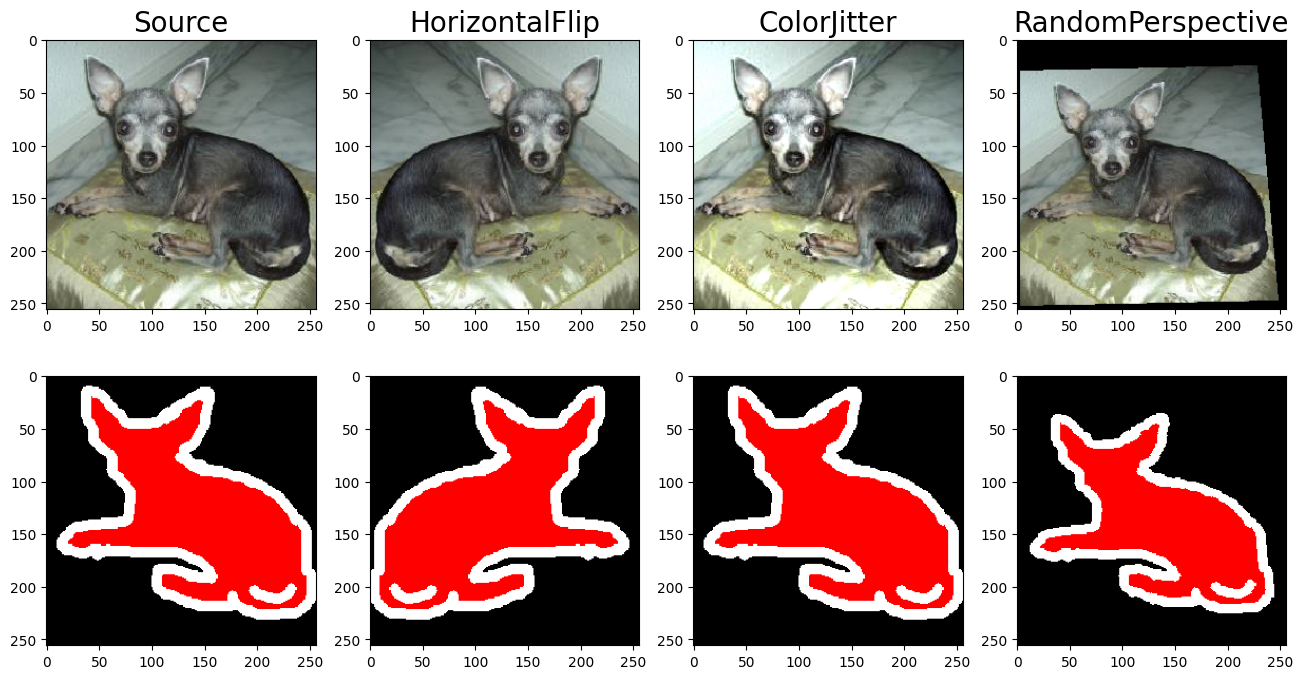

In [11]:
img_idx = np.random.randint(0, 100)
f, ax = plt.subplots(2, 4, figsize=(16, 8))
pair = train_data_hdf5[img_idx]

imgs2draw = {"Source": pair,
            "HorizontalFlip": HorizontalFlip(1.0)(pair),
            "ColorJitter": ColorJitter(1.0, (0.4, 0.4, 0.4))(pair),
            "RandomPerspective": RandomPerspective(1.0, 0.25)(pair)
}
for idx, (name, pair) in enumerate(imgs2draw.items()):
    ax[0, idx].imshow(pair[0])
    ax[0, idx].set_title(name, fontsize=20)
    ax[1, idx].imshow(colorize(np.array(pair[1])))

plt.show()

Далее описываем наш класс `SegmentationData` и операции приведения изображений типа PIL.Image к pytorch тензорам с ImageNet `нормализацией`. ImageNet нормализация - это частный случай [Standard normalization](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html), в котором поканальное среднее (цветовые каналы red, green, blue) и поканальное среднеквадратическое отклонение вычислены на [огромной выборке изображений](https://en.wikipedia.org/wiki/ImageNet).

**Ответьте на вопрос:** `А для чего нужно применять нормализацию к изображениям?`

**Ваш ответ:** 
Нормализация изображений помогает улучшить обучение нейронных сетей, обеспечивая стабильность и уменьшая влияние разных масштабов, освещения и контрастности. Это делает модель более эффективной и устойчивой к различиям в данных.

In [12]:
# Определяем устройство для вычислений (!желательно GPU!)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# конфигурации для преобразования картинок в тензора и обратно (для визуализации и обучения)
t_dict = {
    "forward_input": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]),
    "backward_input": transforms.Compose([
        transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                     std=[1./0.229, 1./0.224, 1./0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                     std=[1.0, 1.0, 1.0]),
        transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
    ]),
    "forward_target": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.long().squeeze().to(DEVICE)),
    ]),
    "backward_target": transforms.Compose([
        transforms.Lambda(lambda x: x.cpu().numpy())
    ]),
    "augment": transforms.Compose([
        HorizontalFlip(0.5),
        ColorJitter(0.5, (0.4, 0.4, 0.4)),
        RandomPerspective(0.5, 0.25)
    ]),
}


class SegmentationDataset(Dataset):
    def __init__(self, dataset_raw: Type[storage_class], transforms: dict, train_flag: bool = True):
        """
        Наследуем весь функционал из `Dataset` для наших данных `dataset_raw`
        `transforms` содержит преобразования PIL.Image <-> torch.tensor и аугментации
        `train_flag` регулирует аугментацию данных (для тестовой выборки она не нужна)
        """
        super().__init__()
        self.dataset_raw = dataset_raw
        self.transforms = transforms
        self.train_flag = train_flag

    def __len__(self):
        return self.dataset_raw.dataset_size

    def __getitem__(self, idx: int) -> tuple[Image_t, Image_t]:
        input, target = self.dataset_raw[idx]

        if (self.train_flag):
            input, target = self.transforms["augment"]((input, target))

        return self.transforms["forward_input"](input), self.transforms["forward_target"](target)

In [13]:
from torch.utils.data import random_split

# Разделяем выборку на обучающую и валидационную
def split_train_val(train_data: Type[storage_class], train_portion: float = 0.8):
    """
    `train_data` предобработанные данные
    `train_portion` доля объектов, которая будет приходиться на обучающую выборку
    """
    trainval_dataset = SegmentationDataset(train_data, t_dict, train_flag=True)

    train_size = int(len(trainval_dataset) * train_portion)
    val_size = len(trainval_dataset) - train_size
    return random_split(trainval_dataset, [train_size, val_size])

train_dataset_hdf5, val_dataset_hdf5 = split_train_val(train_data_hdf5)
train_dataset_memmap, val_dataset_memmap = split_train_val(train_data_memmap)
train_dataset_raw, val_dataset_raw = split_train_val(train_data_raw)

Отрисуем случайное изображение (после применения случайных преобразований аугментации):

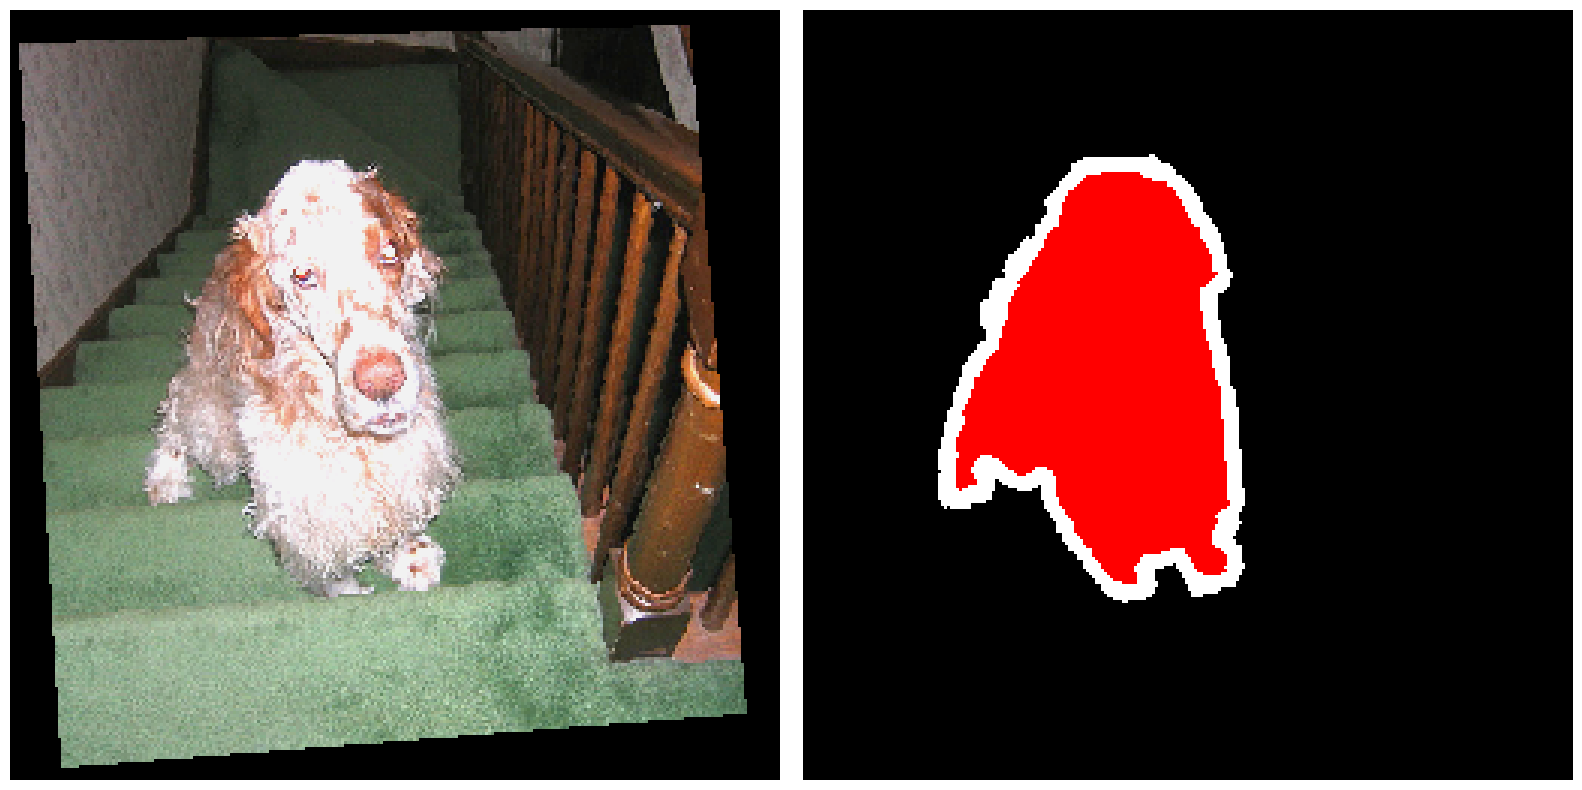

In [14]:
img_idx = np.random.randint(0, 100)
draw(train_dataset_hdf5[img_idx], t_dict);

In [15]:
dataloader_config = {
    "batch_size": 16,
    "shuffle": True,
    "num_workers": 0
}
train_dataloader_hdf5 = DataLoader(train_dataset_hdf5, **dataloader_config)
val_dataloader_hdf5 = DataLoader(val_dataset_hdf5, **dataloader_config)

train_dataloader_memmap = DataLoader(train_dataset_memmap, **dataloader_config)
val_dataloader_memmap = DataLoader(val_dataset_memmap, **dataloader_config)

train_dataloader_raw = DataLoader(train_dataset_raw, **dataloader_config)
val_dataloader_raw = DataLoader(val_dataset_raw, **dataloader_config)

### 1.3 Замер скорости чтения датасета с диска (0.5 балла)

**Замерьте время чтения нашего датасета для каждого из форматов хранения:** (Все SpeedTests вместе занимают около 6 минут!)

In [16]:
def speedtest(dataloader: Type[DataLoader]) -> None:
    for batch in dataloader:
        pass

In [17]:
%timeit speedtest(train_dataloader_hdf5)

49.6 s ± 4.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit speedtest(train_dataloader_memmap)

33 s ± 4.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit speedtest(train_dataloader_raw)

33.7 s ± 4.99 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Ответьте на вопрос: `Какой формат оказался самым эффективным по скорости? Почему?`**

**Ваш ответ:** 
memmap. Он загружает данные частями, минимизируя задержки при чтении данных, поэтому он и эффективен.

**Создайте тестовый Dataloader победившего по скорости формата.**

In [20]:
dataloader_config = {
    "batch_size": 16,
    "shuffle": False,
    "num_workers": 0
}
# используйте: `config_test`, `prepare_dataset`, `SegmentationDataset`, новый `dataloader_config`
test_data = prepare_dataset(config_test, storage_memmap)
test_dataset = SegmentationDataset(test_data, t_dict, train_flag=True)
test_dataloader = DataLoader(test_dataset, **dataloader_config)

# добавьте новые переменные с выбранным форматом
train_dataloader = train_dataloader_memmap
val_dataloader = val_dataloader_memmap


  0%|          | 0/8 [00:00<?, ?it/s]

## Часть 2: Реализация функций потерь, метрик и декодировщика PSPNet

Ранее вас познакомили с архитектурой Unet - сверточными автокодировщиком, применяемом в области сегментации изображений. В данном задании мы разберем более продвинутую архитектуру сети сегментации [PSPNet](https://arxiv.org/abs/1612.01105). Отличительной особенностью этой сети является `Pyramid Pooling Module`, который, в отличие от Unet, позволяет учитывать `глобальный` контекст изображения при формировании признаков его `локальных` областей.

Рассмотрим предлагаемую архитектуру `PSPNet-подобной сети`:
![picture](https://drive.google.com/uc?id=1WNumWndaJAbZBch0dLf6iT8KiSdUbIFG)

В качестве кодировщика `Encoder` будем брать предобученную [ResNeXt](https://pytorch.org/hub/pytorch_vision_resnext/) сеть. Будем его использовать для получения двух глубинных представлений нашего входого изображения `x`:
- **выход `x_main`** (на рисунке: верхний выход Encoder-а ) - "среднее" промежуточное представление, компромисс между низкоуровневыми признаками (цвет, контуры объектов, штрихи) и высокоуровневыми признаками (абстрактные признаки, отражающие семантику изображения)
- **выход `x_supp`** (на рисунке: нижний выход Encoder-а ) - финальное представление, содержащее самые высокоуровневые признаки, в которых значительно утеряна информация о точном простанственном расположении объектов

Подобное разбиение выхода на 2 потока объясняется необходимостью в закодированной информации о пространственном расположении объектов (`x_main`) и вспомогательной информации о семантике всего изображения в целом (`x_supp`) для задачи семантической сегментации. Мы не можем себе позволить использовать лишь выход `x_supp`, как это делается, например, в задачах классификации, ведь от нас требуется дополнительное знание о расположении этого объекта на изображении.

**Ваша задача состоит в написании декодировщика `Decoder`, а именно в написании блоков:**
- **`Pyramid Pooling Module`**. Эта процедура необходима для извлечения глобального контекста разных масштабов, которого не хватает классическим сверточным нейронным сетям (локальный контекст в пределах размера фильтра).
    * К входному тензору `x_main` параллельно применяется несколько операций пулинга разных масштабов и получаются представления таких размеров: `1x1`, `2x2`, `3x3` и `6x6`.
    * Каналы этих промежуточных тензоров эффективно сжимаем (при помощи `nn.Conv2d c размером фильтра 1x1`). Делаем это для сжатия информации, а также для индивидуального взвешивания каждого тензора (назовем их тензорами глобального контекста разного масштаба).
    * Затем восстанавливаем полученные тензоры до исходных размеров с помощью интерполяции.
    * Выходной тензор получаем конкатенацией этих глобальных контекстов. Каждый контекст содержит информацию о всем изначальном изображении с разными уровнями детализации. Требуется реализовать `forward` этап этого блока. Для уточнения информации можно обратиться к [статье](https://arxiv.org/abs/1612.01105).
- **`Supplementary Module`** осуществляет нелинейное преобразование над входным тензором `x_supp` с понижением числа каналов до числа на выходе модуля **`Pyramid Pooling Module`**. Вариант архитектуры этого преобразования (композиции слоев) уже предложен, но, при желании, вы можете с ним экспериментировать
- **`Upsample Module`** осуществляет нелинейные преобразования над входным тензором с понижением числа каналов, которые чередуются с увеличением с помощью интерполяции пространственных размерностей в 2 раза. В результатае преобразований выход этого блока имеет ту же пространственную размерность, что и входное в кодировщик изображение.
- **`Segmentation Head`** нелинейно преобразует входной тензор в тензор score'ов. Выходной тензор для каждого пикселя имеет `num_classes` score'ов (в нашем случае 3). Индекс максимального score'а для заданного пикселя есть его метка класса (0, 1 или 2).

### 2.1 Кодировщик и декодировщик PSPNet-подобной сети (3 балла)

In [21]:
from torchvision.models.resnet import ResNet

pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

# Выставляем evaluation mode (влияет на поведение таких слоев как BatchNorm2d, Dropout)
pretrained_model.eval();

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 70.5MB/s]


Так как кодировщик используется предобученный, то требуется зафиксировать (заморозить) веса, чтобы по ним не тек градиент. Этим мы гарантируем, что кодировщик не изменяется в ходе обучения автокодировщика, а также экономим вычислительные ресурсы (граф градиента кодировщика не строится).

In [22]:
class EncoderBlock(nn.Module):
    def __init__(self, pretrained_model: Type[ResNet]):
        """
        Извлекает предобученные именованные слои кодировщика `pretrained_model`
        Разделяет слои на `main` и `supp` потоки (см. архитектуру выше)

        Вход: тензор (Batch_size, 3, Height, Width)

        Выход: x_main тензор (Batch_size, 512, Height // 8, Width // 8)
        Выход: x_supp тензор (Batch_size, 2048, Height // 32, Width // 32)
        """
        super().__init__()

        self.encoder_main = nn.Sequential()
        for name, child in list(pretrained_model.named_children())[:-4]:
            print(f"Pretrained main module {name} is loaded")
            self.encoder_main.add_module(name, child)

        self.encoder_supp = nn.Sequential()
        for name, child in list(pretrained_model.named_children())[-4:-2]:
            print(f"Pretrained supp module {name} is loaded")
            self.encoder_supp.add_module(name, child)

    def freeze(self) -> None:
        """
        Замораживает веса кодировщика
        """
        for p in self.parameters():
            p.requires_grad = False
        self.eval()

    def unfreeze(self) -> None:
        """
        Размораживает веса кодировщика
        """
        for p in self.parameters():
            p.requires_grad = True
        self.train()

    def forward(self, x: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
        x_main = self.encoder_main(x)
        x_supp = self.encoder_supp(x_main)
        return x_main, x_supp

In [23]:
encoder = EncoderBlock(pretrained_model)

Pretrained main module conv1 is loaded
Pretrained main module bn1 is loaded
Pretrained main module relu is loaded
Pretrained main module maxpool is loaded
Pretrained main module layer1 is loaded
Pretrained main module layer2 is loaded
Pretrained supp module layer3 is loaded
Pretrained supp module layer4 is loaded


**Для оценки сложности модели нам понадобится функция подсчета числа ее параметров, для этого используйте метод [model.parameters()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters). Реализуйте ее ниже:**

In [24]:
def count_parameters(model: Type[nn.Module]) -> int:
    """
    Считает число весов в модели `model`, для которых требуется градиент
    * Используйте model.parameters() чтобы получить список параметров:
        https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters
    * Используйте requires_grad, для проверки, считается ли для данного параметра градиент:
        https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter
    """
    total_params = 0
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

Убедимся, что метод `.freeze()` успешно замораживает веса:

In [25]:
print("Encoder #parameters before freeze():", count_parameters(encoder))
encoder.freeze()
print("Encoder #parameters after freeze():", count_parameters(encoder))

Encoder #parameters before freeze(): 22979904
Encoder #parameters after freeze(): 0


* **Реализуйте `PyramidPoolingModule`, `Upsample` и `SegmentationHead` (по 1 баллу)**

In [26]:
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bin_sizes: tuple[int, ...]):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)
        `bin_sizes` - пространственные размерности для каждой пулинг операции
        Пример: bin_sizes = (1, 2, 3, 6).

        Выход: тензор (Batch_size, `in_channels` + len(`bin_sizes`) * `out_channels`, Height, Width)
        """
        super().__init__()
        self.bins = []

        for bin_size in bin_sizes:
            self.bins.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin_size), # почитайте: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
                nn.Conv2d(in_channels, out_channels, kernel_size=1), # почитайте: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
                nn.BatchNorm2d(out_channels), # почитайте: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
                nn.ReLU(inplace=True)
            ))

        self.bins = nn.ModuleList(self.bins)

    def forward(self, x: torch.tensor) -> torch.tensor:
        h, w = x.shape[2:]
        out = [x,]
        """
        * Пройдитесь циклом по self.bins и примените исходное изображение отдельно
          к каждому  блоку операций Pooling + Conv + BatchNorm + ReLU
        * После применения не забудьте на каждый выход сделать `Upscale`
          (используйте torch.functional.interpolate)
          и добавить результат в список `out`
        * Сконкатенируйте тензоры из out в один большой тензор по размерности с каналами
          с помощью torch.cat
        """
        for bin_layes in self.bins:
            pooled = bin_layes(x)
            upscaled = F.interpolate(pooled, size=(h, w), mode='bilinear', align_corners=True)
            out.append(upscaled)
        return torch.cat(out, dim=1)


class SupplementaryModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout: float):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)

        Выход: тензор (Batch_size, `out_channels`, Height, Width)
        """
        super().__init__()
        self.suppl = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(in_channels // 2, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.suppl(x)


class Upsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)

        Выход: тензор (Batch_size, `out_channels`, 2 * Height, 2 * Width)
        """
        super().__init__()

        # Рекомендуем попробовать Conv2d (kernel: 3x3, padding=1) + BatchNorm2d + ReLU
        self.us_transform = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Увеличьте входное изображение в два раза, а затем примените us_transform
        Используйте torch.functional.interpolate c mode='bilinear', align_corners=True
        """
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        return self.us_transform(x)




class UpsampleModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)

        Выход: тензор (Batch_size, `out_channels`, 8 * Height, 8 * Width)
        """
        super().__init__()
        self.upsample = nn.Sequential(
            Upsample(in_channels, in_channels // 4),
            Upsample(in_channels // 4, in_channels // 8),
            Upsample(in_channels // 8, out_channels)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.upsample(x)

In [27]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bin_sizes: tuple[int, ...], dropout: float = 0.1):
        """
        Вход  x_main: тензор (Batch_size, `in_channels`, Height, Width)
        Вход  x_supp: тензор (Batch_size, 4 * `in_channels`, Height // 4, Width // 4)

        Выход: тензор (Batch_size, `out_channels`, 8 * Height, 8 * Width)
        """
        super().__init__()
        assert in_channels % len(bin_sizes) == 0

        self.PPM = PyramidPoolingModule(in_channels, in_channels // len(bin_sizes), bin_sizes)
        self.SM = SupplementaryModule(4 * in_channels, 2 * in_channels, dropout)
        self.UM = UpsampleModule(4 * in_channels, out_channels)

    def forward(self, x_main: torch.tensor, x_supp: torch.tensor) -> torch.tensor:
        h_supp, w_supp = x_supp.shape[2:]
        x_supp = F.interpolate(input=x_supp, size=(4 * h_supp, 4 * w_supp), mode='bilinear', align_corners=True)

        x_supp = self.SM(x_supp)
        x_main = self.PPM(x_main)

        out = self.UM(torch.cat([x_main, x_supp], dim=1))
        return out


class SegmentationHead(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, dropout: float = 0.1):
        """
        Вычисляет score для каждого из классов
        Вход: тензор (Batch_size, `in_channels`, Height, Width)

        Выход: тензор (Batch_size, `num_classes`, Height, Width)
        """
        super().__init__()
        # Рекомендуем попробовать: BatchNorm2d + ReLU + Dropout2d + Conv2d (1 x 1)
        self.segmentation_head = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(in_channels, num_classes, kernel_size=1)
        )

    def forward(self, x: torch.tensor, x_supp: torch.tensor) -> torch.tensor:
        """
        На будущее зададим фиктивный аргумент `x_supp`, который пока не будем использовать
        """
        return self.segmentation_head(x)

### 2.2 Реализация метрик (3.5 балла)

В задаче сегментации для оценки предсказательной способности нейронной сети, в основном, используют следующие метрики:

Пусть $\mathrm{P}$ обозначает прогноз сег. маски (Prediction), $\mathrm{S}$ обозначает score'ы для каждого класса сег. маски (Scores), а $\mathrm{T}$ означает сег. маску (Target). Тогда:
- **Intersection over Union metric (коэффициент Жаккара)**:
$$
\mathrm{IoU}(P, T) = \dfrac{\sum_{i=1}^{M}\sum_{j=1}^{N}[P_{ij}*T_{ij}]}{\sum_{i=1}^{M}\sum_{j=1}^{N} [P_{ij} + T_{ij} - P_{ij}*T_{ij}]}\text{, где } P, T \in \{0, 1\}^{M \times N}
$$
- **Recall metric (полнота)**:
$$
\mathrm{Recall}(P, T) = \dfrac{\sum_{i=1}^{M}\sum_{j=1}^{N}[P_{ij} * T_{ij}]}{\sum_{i=1}^{M}\sum_{j=1}^{N} T_{ij}}\text{, где } P, T \in \{0, 1\}^{M \times N}
$$
Указанные выше метрики расписаны для случая бинарной сегментации, которая нам не подходит. Обобщим их на случай мультиклассовой сегментации: представим K-классовую задачу как K двухклассовых, а затем `макро-` или `микро-`усредним для них метрики. **Требуется реализовать мультиклассовые варианты указанных метрик с поддержкой макро- и микро-усреднения (по 1 баллу). Обратите внимание, что метрики рассчитываются для каждого элемента из батча. За редуцирование метрик вдоль размерности батча отвечает аргумент `reduce` (см. ниже).**

Также для обучения будем использовать две разные, но схожие функции потерь:
- Cross Entropy Loss (кросс-энтропия):
$$
\mathrm{CE}(S, T) = - \dfrac{1}{MN}\sum_{c=1}^{K}\sum_{i=1}^{M}\sum_{j=1}^{N} \big[\log \mathrm{Softmax}(S)_{cij}*\mathbb{I}[T_{ij} == c]\big]\text{, где } S \in \mathbb{R}^{K \times M \times N}, T \in \{1, ..., K\}^{M \times N}
$$
- [Focal Loss](https://arxiv.org/abs/1708.02002):
$$
\mathrm{FL}(S, T) = - \dfrac{1}{MN}\sum_{c=1}^{K}\sum_{i=1}^{M}\sum_{j=1}^{N} \big[(1 - \mathrm{Softmax}(S)_{cij})^{\gamma}*\log \mathrm{Softmax}(S)_{cij}*\mathbb{I}[T_{ij} == c]\big]\text{, где } S \in \mathbb{R}^{K \times M \times N}, T \in \{1, ..., K\}^{M \times N}, \gamma \in \mathbb{R}_{+} - \text{гиперпараметр}
$$

**Функции потерь реализовывать не требуется**. Также всюду необходимо обеспечить корректную обработку значений `ignore_index`, которые в нашем случае равны 255 (не участвуют в расчете метрик/функций потерь). Если представители некоторых классов в $\mathrm{T}$ отсутствуют, то учитывать эти классы при макро-усреднении не нужно.

In [34]:
class MetricsCollection():
    def __init__(self, num_classes: int, ignore_index: int = 255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index

    def IoUMetric(self, prediction: torch.tensor, target: torch.tensor, average: str = "macro", reduce: str = "mean") -> Union[torch.tensor, float]:
        """
        `prediction` предсказанная сегментационная маска размера (Batch_size, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `average` тип мультклассового усреднения
        `reduce` редукция значений метрики вдоль размерности Batch; None - без редукции
        """

        """
        micro - суммируем знаменатель для всех классов, числитель для всех классов
                и делим одно на другое
        macro - считаем метрику по каждому классу отдельно, затем усредняем
        """
        assert average in ["micro", "macro"]

        """
        sum - сумма метрик по всем картинкам
        mean - среднее метрик по всем картинкам
        none - массив метрик по всем картинкам
        """
        assert reduce in ["sum", "mean", "none"]

        batch_size = prediction.shape[0]
        ious = []

        for batch_idx in range(batch_size):
            pred = prediction[batch_idx]
            targ = target[batch_idx]

            # Игнорируем пиксели с `ignore_index`
            valid_mask = targ != self.ignore_index

            iou_per_class = []
            for cls in range(self.num_classes):
                if (targ == cls).sum() == 0:
                    # Пропустить классы, которые отсутствуют в маске
                    continue

                pred_cls = (pred == cls).float() * valid_mask
                targ_cls = (targ == cls).float() * valid_mask

                intersection = torch.sum(pred_cls * targ_cls)
                union = torch.sum(pred_cls + targ_cls) - intersection

                if union == 0:
                    iou_per_class.append(torch.tensor(0.0, device=prediction.device))
                else:
                    iou_per_class.append(intersection / union)

            if average == "macro":
                iou_value = torch.mean(torch.stack(iou_per_class)) if iou_per_class else torch.tensor(0.0)
            elif average == "micro":
                total_intersection = torch.sum(torch.stack([torch.sum((pred == c).float() * (targ == c).float() * valid_mask) for c in range(self.num_classes)]))
                total_union = torch.sum(torch.stack([torch.sum(((pred == c).float() + (targ == c).float()) * valid_mask) for c in range(self.num_classes)])) - total_intersection
                iou_value = total_intersection / total_union if total_union != 0 else torch.tensor(0.0)

            ious.append(iou_value)

        ious = torch.stack(ious)

        if reduce == "mean":
            return ious.mean()
        elif reduce == "sum":
            return ious.sum()
        else:
            return ious



    def RecallMetric(self, prediction: torch.tensor, target: torch.tensor, average: str = "macro", reduce: str = "mean") -> Union[torch.tensor, float]:
        """
        `prediction` предсказанная сегментационная маска размера (Batch_size, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `average` тип мультклассового усреднения
        `reduce` редукция значений метрики вдоль размерности Batch; None - без редукции
        """

        """
        micro - суммируем знаменатель для всех классов, числитель для всех классов
                и делим одно на другое
        macro - считаем метрику по каждому классу отдельно, затем усредняем
        """
        assert average in ["micro", "macro"]

        """
        sum - сумма метрик по всем картинкам
        mean - среднее метрик по всем картинкам
        none - массив метрик по всем картинкам
        """
        assert reduce in ["sum", "mean", "none"]
        
        batch_size = prediction.shape[0]
        recalls = []

        for batch_idx in range(batch_size):
            pred = prediction[batch_idx]
            targ = target[batch_idx]

            # Игнорируем пиксели с `ignore_index`
            valid_mask = targ != self.ignore_index

            recall_per_class = []
            for cls in range(self.num_classes):
                if (targ == cls).sum() == 0:
                    # Пропустить классы, которые отсутствуют в маске
                    continue

                pred_cls = (pred == cls).float() * valid_mask
                targ_cls = (targ == cls).float() * valid_mask

                true_positive = torch.sum(pred_cls * targ_cls)
                actual_positive = torch.sum(targ_cls)

                if actual_positive == 0:
                    recall_per_class.append(torch.tensor(0.0, device=prediction.device))
                else:
                    recall_per_class.append(true_positive / actual_positive)

            if average == "macro":
                recall_value = torch.mean(torch.stack(recall_per_class)) if recall_per_class else torch.tensor(0.0)
            elif average == "micro":
                total_true_positive = torch.sum(torch.stack([torch.sum((pred == c).float() * (targ == c).float() * valid_mask) for c in range(self.num_classes)]))
                total_actual_positive = torch.sum(torch.stack([torch.sum((targ == c).float() * valid_mask) for c in range(self.num_classes)]))
                recall_value = total_true_positive / total_actual_positive if total_actual_positive != 0 else torch.tensor(0.0)

            recalls.append(recall_value)

        recalls = torch.stack(recalls)

        if reduce == "mean":
            return recalls.mean()
        elif reduce == "sum":
            return recalls.sum()
        else:
            return recalls

    def FocalLoss(self, scores: torch.tensor, target: torch.tensor, reduce: str = "mean", gamma: float = 1.) -> Union[torch.tensor, float]:
        """
        `scores` score'ы каждого класса сегментационной маски размера (Batch_size, num_classes, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `reduce` редукция значений функции потерь вдоль размерности Batch; None - без редукции
        """
        assert scores.shape[1] == self.num_classes
        assert reduce in ["sum", "mean", "none"]

        ce_loss = F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="none")
        coef = (1 - torch.exp(-ce_loss))**gamma
        focal_loss = coef * ce_loss
        norm = (focal_loss.numel() - (target == self.ignore_index).sum())

        if (reduce == "sum"):
            return focal_loss.sum() / norm * scores.shape[0]
        elif (reduce == "mean"):
            return focal_loss.sum() / norm
        else:
            return focal_loss.sum(dim=[1, 2]) / norm * scores.shape[0]

    def CrossEntropyLoss(self, scores: torch.tensor, target: torch.tensor, reduce: str = "mean") -> Union[torch.tensor, float]:
        """
        `scores` score'ы каждого класса сегментационной маски размера (Batch_size, num_classes, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `reduce` редукция значений функции потерь вдоль размерности Batch; None - без редукции
        """
        assert scores.shape[1] == self.num_classes
        assert reduce in ["sum", "mean", "none"]

        if (reduce == "sum"):
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="mean") * scores.shape[0]
        elif (reduce == "mean"):
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="mean")
        else:
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="none")

    @classmethod
    def ListMetrics(cls):
        return [method for method in dir(cls) if (method.endswith("Metric"))]

    @classmethod
    def ListLosses(cls):
        return [method for method in dir(cls) if (method.endswith("Loss"))]

In [35]:
metric_class = MetricsCollection(num_classes=3, ignore_index=255)

prediction = torch.tensor([[[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 1, 0], [0, 0, 0, 0]],
                           [[0, 0, 0, 0], [0, 2, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]]])

target = torch.tensor([[[0, 0, 0, 0], [0, 1, 255, 0], [0, 1, 255, 0], [0, 0, 0, 0]],
                       [[0, 0, 0, 0], [0, 255, 2, 0], [0, 255, 2, 0], [0, 0, 0, 0]]])

assert np.isclose(metric_class.RecallMetric(prediction, target, "micro", "mean").item(), 0.9286, atol=1e-3)
assert np.isclose(metric_class.RecallMetric(prediction, target, "macro", "mean").item(), 0.7500, atol=1e-3)
assert np.isclose(metric_class.IoUMetric(prediction, target, "micro", "mean").item(), 0.8667, atol=1e-3)
assert np.isclose(metric_class.IoUMetric(prediction, target, "macro", "mean").item(), 0.7115, atol=1e-3)

**Ответьте на вопрос (№1):** `Что говорит о предсказательной способности нашей сети ситуация: высокий Recall и низкий IoU для некоторого класса? Возможна ли обратная ситуация?`

**Ваш ответ:** 
Высокий Recall и низкий IoU для некоторого класса указывают на то, что сеть успешно распознает большинство объектов данного класса, но делает это с низкой точностью.

Обратная ситуация — низкий Recall и высокий IoU. Модель предсказывает границы объектов с высокой точностью, но пропускает многие объекты (низкий Recall).

**Ответьте на вопрос (№2):** `Какой вид усреднения правильней использовать в нашей задаче: макро и микро? Почему?`

**Ваш ответ:** 
правильнее использовать усреднение "микро". Так как усреднение "микро" учитывает общее количество верных пиксельных предсказаний для всех классов и позволяет оценить общую производительность модели, что особенно важно в задачах с несбалансированными классами.

**Ответьте на вопрос (№3):** `В чем преимущество Focal Loss перед Cross Entropy Loss? Что контроллирует гиперпараметр 𝛾 в Focal Loss?`

**Ваш ответ:** 
Основное преимущество Focal Loss перед Cross Entropy Loss состоит в его способности более эффективно решать проблему сильного дисбаланса классов за счет снижения значимости легко классифицируемых примеров.

Гиперпараметр 𝛾 в Focal Loss регулирует степень уменьшения вклада легко классифицируемых примеров. С увеличением значения 𝛾 акцент смещается на сложные для классификации случаи, тогда как при снижении 𝛾 влияние легко классифицируемых примеров становится более заметным.

## Часть 3: Обучение PSPNet, эксперименты

Теперь **осталось лишь собрать все написанное ранее воедино и обучить нашу сеть**. Чтобы контроллировать процесс обучения нашей сети, будем вычислять усредненные метрики и функции потерь на валидационной выборке. Для удобства отображения информации **воспользуемся инструментом `tensorboard`**. Для этого заведем объект класса `SummaryWriter`, который создаст и откроет на запись специальный `event` файл для [tensorboard](https://pytorch.org/docs/stable/tensorboard.html). Для визуализации содержимого вводится команда `tensorboard --logdir=<PATH>` в терминале. Если возникла необходимость в мониториге нескольких tensorboard, то каждому из них требуется присвоить свой уникальный порт `--port <PORT>`. [Пример](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensorboard_with_pytorch.ipynb#scrollTo=lFKETpE2F2oE) использования tensorboard на Google Colab.

**Требуется написать методы `train_model` и `test_model`. Вся конфигурация обучения хранится в словаре `train_config`. При желании его можно дополнить чем-то своим.**

**К вашему решению потребуется прикрепить логи tensorboard. Чтобы облегчить процедуру проверки настоятельно рекомендуется пользоваться `inline-tensorboard`:**
```
%load_ext tensorboard
%tensorboard --logdir ./runs
```

### 3.1 Реализация процедур обучения/тестирования сети (1 балл)

In [39]:
class PSPNet(nn.Module):
    def __init__(self, pretrained_model: Type[ResNet], HeadBlock: Type[nn.Module], num_classes: int, train_config: dict, bin_sizes: tuple[int, ...] = (1, 2, 3, 6)):
        """
        `pretrained_model` модель предобученного кодировщика
        `Head` класс блока, оценивающего score'ы для каждого класса сегментационной маски
        `num_class` число классов сегментации
        `train_config` словарь с конфигурацией процесса обучения сети
        `bin_sizes` пространственные размеры к которым сводит пулинг в блоке PPM
        """
        super().__init__()
        self.encoder = EncoderBlock(pretrained_model)
        self.encoder.freeze()
        self.decoder = DecoderBlock(512, 128, bin_sizes)
        self.head = HeadBlock(128, num_classes)

        self.train_config = train_config
        self.metric_class = train_config["metric_class"]
        self.optimizer = train_config["optimizer"](self.parameters(), **train_config["optimizer_params"])
        self.scheduler = train_config["scheduler"](self.optimizer, **train_config["scheduler_params"])

    def forward(self, x: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
        # Для гарантии отсутствия градиентов по кодировщику
        with torch.no_grad():
            x_main, x_supp = self.encoder(x)
        out = self.decoder(x_main, x_supp)
        out = self.head(out, x_supp)
        return out, torch.argmax(out.detach(), dim=1)

    def write_val_metrics(self, val_metrics: dict, iter_num: int, norm: float = 1.0) -> None:
        """
        Записывает усредненные значения метрик/функций потерь в tensorboard

        `val_metrics` словарь с ключами "название_метрики/функции потерь" и их значениями
        `iter_num` номер глобальной итерации (по формуле #всего_итераций * номер_эпохи + номер_итерации)
        `norm` фактор нормализации; для усреднения равен числу объектов в валидационной выборке
        """
        for method, value in val_metrics.items():
            self.train_config["writer"].add_scalar(f"Mean {method}", np.round(val_metrics[method].item()/norm, 2), iter_num)

    def validate_model(self, val_dataloader: Type[DataLoader], iter_num: int) -> None:
        """
        Валидирует текущую модель и вычисляет соответствующие метрики/функции потерь

        `val_dataloader` валидационная выборка
        `iter_num` номер глобальной итерации (по формуле #всего_итераций * номер_эпохи + номер_итерации)
        """
        # Выставляет декодировщик в режим валидации (влияет на поведение BatchNorm2d и Dropout)
        self.decoder.eval()
        self.head.eval()

        # Инициализация словаря метрик/функций потерь
        val_metrics = dict([(method, 0.0) for method in (self.metric_class.ListMetrics() + self.metric_class.ListLosses())])

        # Обязательно считать с контекстным менеджером torch.no_grad()
        # Даже если мы не делаем шаг оптимизации, мы экономим память (не считаем градиенты)
        with torch.no_grad():
            for input, target in val_dataloader:
                scores, prediction = self.forward(input)
                for metric in self.metric_class.ListMetrics():
                    val_metrics[metric] += getattr(self.metric_class, metric)(prediction, target, reduce="sum")

                for loss in self.metric_class.ListLosses():
                    val_metrics[loss] += getattr(self.metric_class, loss)(scores, target, reduce="sum")

        # Tensorboard также позволяет сохранять визуализацию наших предсказаний в ходе обучения
        figure = draw((input[0], target[0]), t_dict, prediction[0], log=True)
        self.train_config["writer"].add_figure("image/GT/prediction", figure, iter_num)

        self.write_val_metrics(val_metrics, iter_num, norm=len(val_dataloader.dataset))
        # Возвращает режим обучения декодировщика
        self.decoder.train()

    def train_model(self, train_dataloader: Type[DataLoader], val_dataloader: Type[DataLoader]) -> None:
        """
        Обучает модель на обучающей выборке, периодически (периодичность выставляется в train_config) валидирует на валидационной выборке
        В конце каждой эпохи сохраняет модель на диск

        `train_dataloader` обучающая выборка
        `val_dataloader` валидационная выборка
        """
        # Выставляет режим обучения декодировщика
        self.decoder.train()
        self.head.train()

        for epoch in range(self.train_config["num_epochs"]):
            for iter_num, (input, target) in enumerate(train_dataloader):
                self.optimizer.zero_grad()
                scores, _ = self.forward(input)
                loss = self.train_config["loss_fn"](scores, target, reduce="mean")
                loss.backward()
                self.optimizer.step()

                if (iter_num % self.train_config["validate_each_iter"] == 0):
                    print(f"Epoch: {epoch+1}/{self.train_config['num_epochs']} || Iter: {iter_num}/{len(train_dataloader)} || Loss: {loss.item()}")
                    self.validate_model(val_dataloader, epoch * len(train_dataloader) + iter_num)
            self.scheduler.step()

            torch.save(self.state_dict(), self.train_config["save_model_path"] + f"_{epoch+1}.pth")

    def test_model(self, test_dataloader: Type[DataLoader]) -> tuple[torch.tensor, torch.tensor]:
        """
        Inference модели на тестовой выборке. Возвращает тензор предсказаний сег.масок и тензор истинных сег.масок

        `test_dataloader` тестовая выборка
        """
        # Выставляет декодировщик в режим валидации (влияет на поведение BatchNorm2d и Dropout)
        self.decoder.eval()
        self.head.eval()

        dl_prediction = []
        dl_target = []

        # Отключаем вычисление градиентов для экономии памяти
        with torch.no_grad():
            for input, target in test_dataloader:
                _, prediction = self.forward(input)
                
                # Сохраняем предсказания и истинные метки
                dl_prediction.append(prediction.cpu())
                dl_target.append(target.cpu())

        # Конкатенируем списки тензоров в один тензор
        dl_prediction = torch.cat(dl_prediction, dim=0)
        dl_target = torch.cat(dl_target, dim=0)

        return dl_prediction, dl_target

### 3.2 Обучение PSPNet, эксперименты (5 баллов)

Вам приведены начальные значения гиперпараметров сети. Подберите гиперпараметры (если необходимо) и обучите сеть на обе функции потерь `CrossEntropyLoss` и `FocalLoss`. Добейтесь следующих результатов на тестовой выборке хотя бы для одной из них:
- **`Mean IoU metric` > 0.82**
- **`Mean Recall metric` > 0.92**

К вашему решению требуется прикрепить логи tensorboard.

**CrossEntropyLoss**

In [40]:
from torch.optim.lr_scheduler import StepLR

train_config = {
    "num_epochs": 2, # примерное время обучения ~ 20 минут на GPU
    "optimizer": torch.optim.Adam,
    "optimizer_params": {
        "lr": 1e-3,
        "weight_decay": 1e-5
    },
    "loss_fn": metric_class.CrossEntropyLoss,
    "scheduler": StepLR,
    "scheduler_params": {
        "step_size": 50,
        "gamma": 0.85
    },
    "validate_each_iter": 10,
    "writer": SummaryWriter(comment="CEloss"),
    "save_model_path": "model_celoss",
    "metric_class": metric_class
}

net = PSPNet(pretrained_model, SegmentationHead, num_classes=3, train_config=train_config).to(DEVICE)
print("#параметров в сети:", count_parameters(net))

Pretrained main module conv1 is loaded
Pretrained main module bn1 is loaded
Pretrained main module relu is loaded
Pretrained main module maxpool is loaded
Pretrained main module layer1 is loaded
Pretrained main module layer2 is loaded
Pretrained supp module layer3 is loaded
Pretrained supp module layer4 is loaded
#параметров в сети: 31107843


In [42]:
%load_ext tensorboard

In [43]:
net.train_model(train_dataloader, val_dataloader)

Epoch: 1/2 || Iter: 0/184 || Loss: 0.8358926773071289
Epoch: 1/2 || Iter: 10/184 || Loss: 0.396403968334198
Epoch: 1/2 || Iter: 20/184 || Loss: 0.23480558395385742
Epoch: 1/2 || Iter: 30/184 || Loss: 0.2819885313510895
Epoch: 1/2 || Iter: 40/184 || Loss: 0.2132972776889801
Epoch: 1/2 || Iter: 50/184 || Loss: 0.2042044848203659
Epoch: 1/2 || Iter: 60/184 || Loss: 0.19055122137069702
Epoch: 1/2 || Iter: 70/184 || Loss: 0.1755775809288025
Epoch: 1/2 || Iter: 80/184 || Loss: 0.1737866997718811
Epoch: 1/2 || Iter: 90/184 || Loss: 0.253978431224823
Epoch: 1/2 || Iter: 100/184 || Loss: 0.16956335306167603
Epoch: 1/2 || Iter: 110/184 || Loss: 0.13744227588176727
Epoch: 1/2 || Iter: 120/184 || Loss: 0.2726273834705353
Epoch: 1/2 || Iter: 130/184 || Loss: 0.14310264587402344
Epoch: 1/2 || Iter: 140/184 || Loss: 0.23747624456882477
Epoch: 1/2 || Iter: 150/184 || Loss: 0.28537049889564514
Epoch: 1/2 || Iter: 160/184 || Loss: 0.12398096174001694
Epoch: 1/2 || Iter: 170/184 || Loss: 0.18788442015647

In [44]:
# Протестируйте модель:
net.load_state_dict(torch.load("model_celoss_2.pth")) # Не забудьте поменять версию `_1`-> `_n` если запускаете несколько раз!
net.eval();
dl_prediction, dl_target = net.test_model(test_dataloader)
print("Mean IoU metric: ", metric_class.IoUMetric(dl_prediction, dl_target))
print("Mean Recall metric: ", metric_class.RecallMetric(dl_prediction, dl_target))

/tmp/ipykernel_3393024/780372532.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("model_celoss_2.pth")) # Не забудьте поменять версию `_1`

Mean IoU metric:  tensor(0.8900)
Mean Recall metric:  tensor(0.9468)


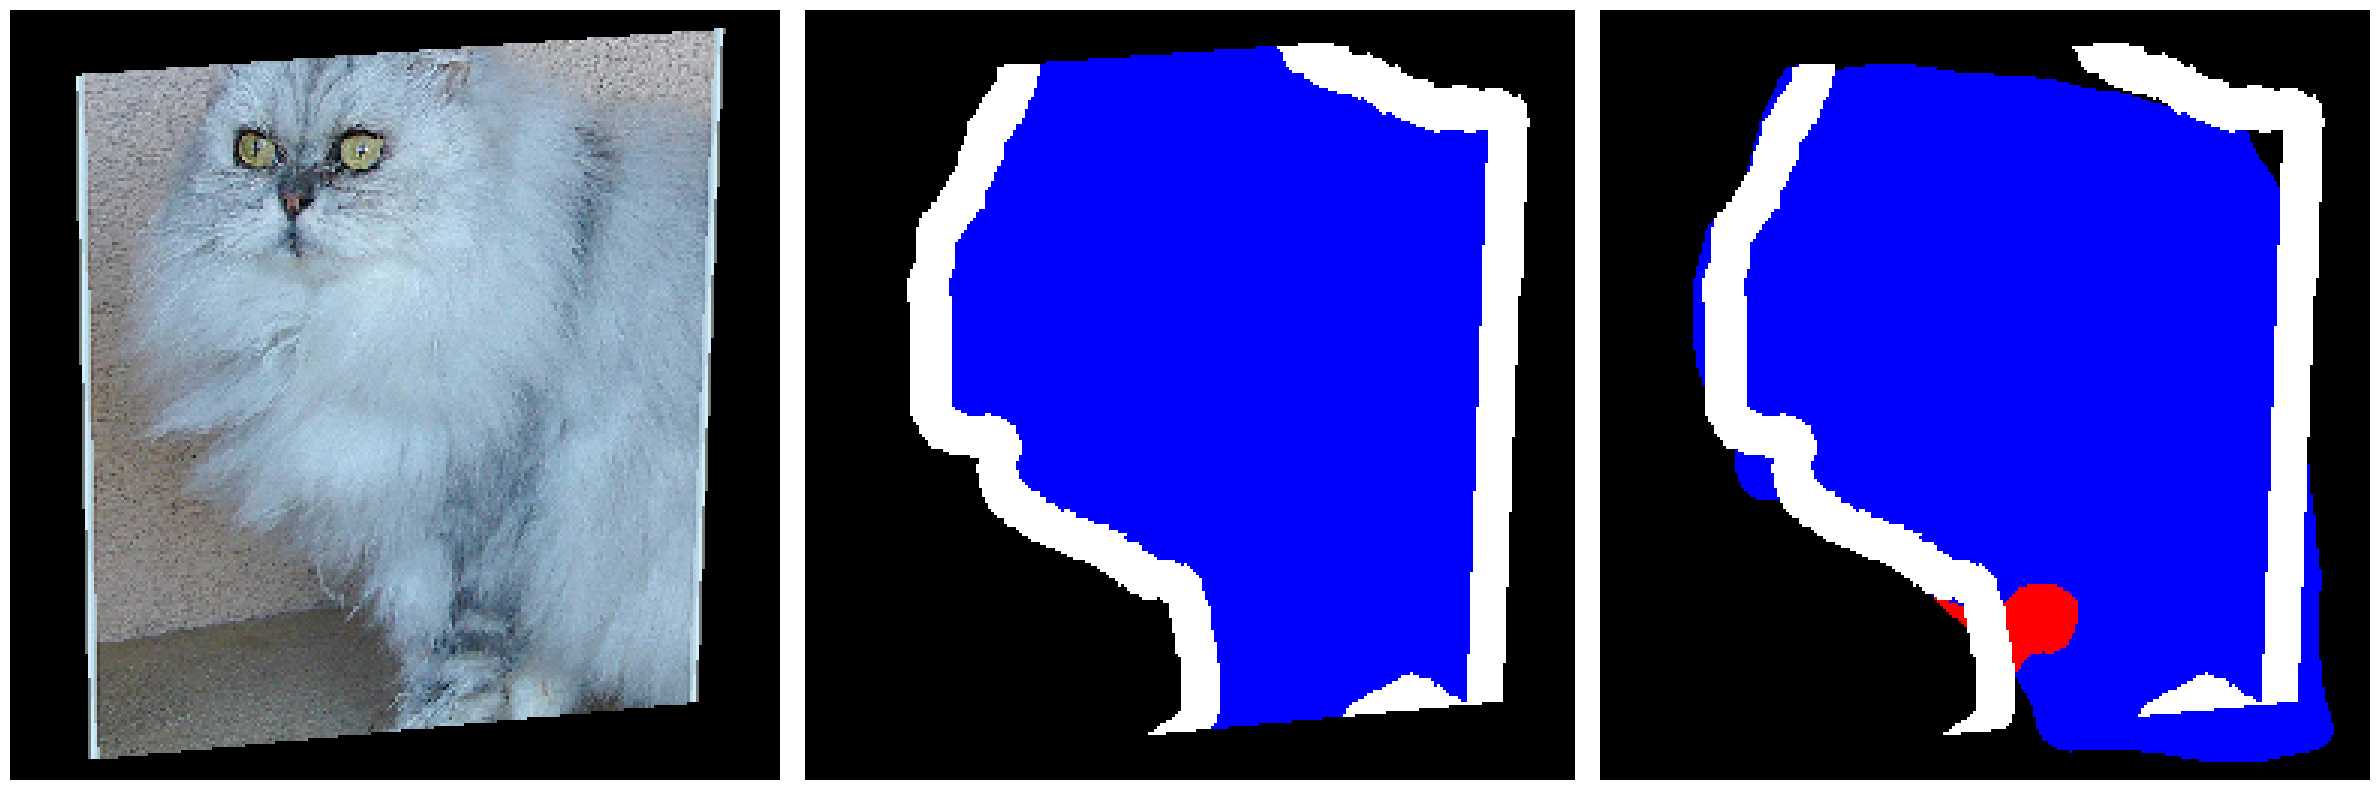

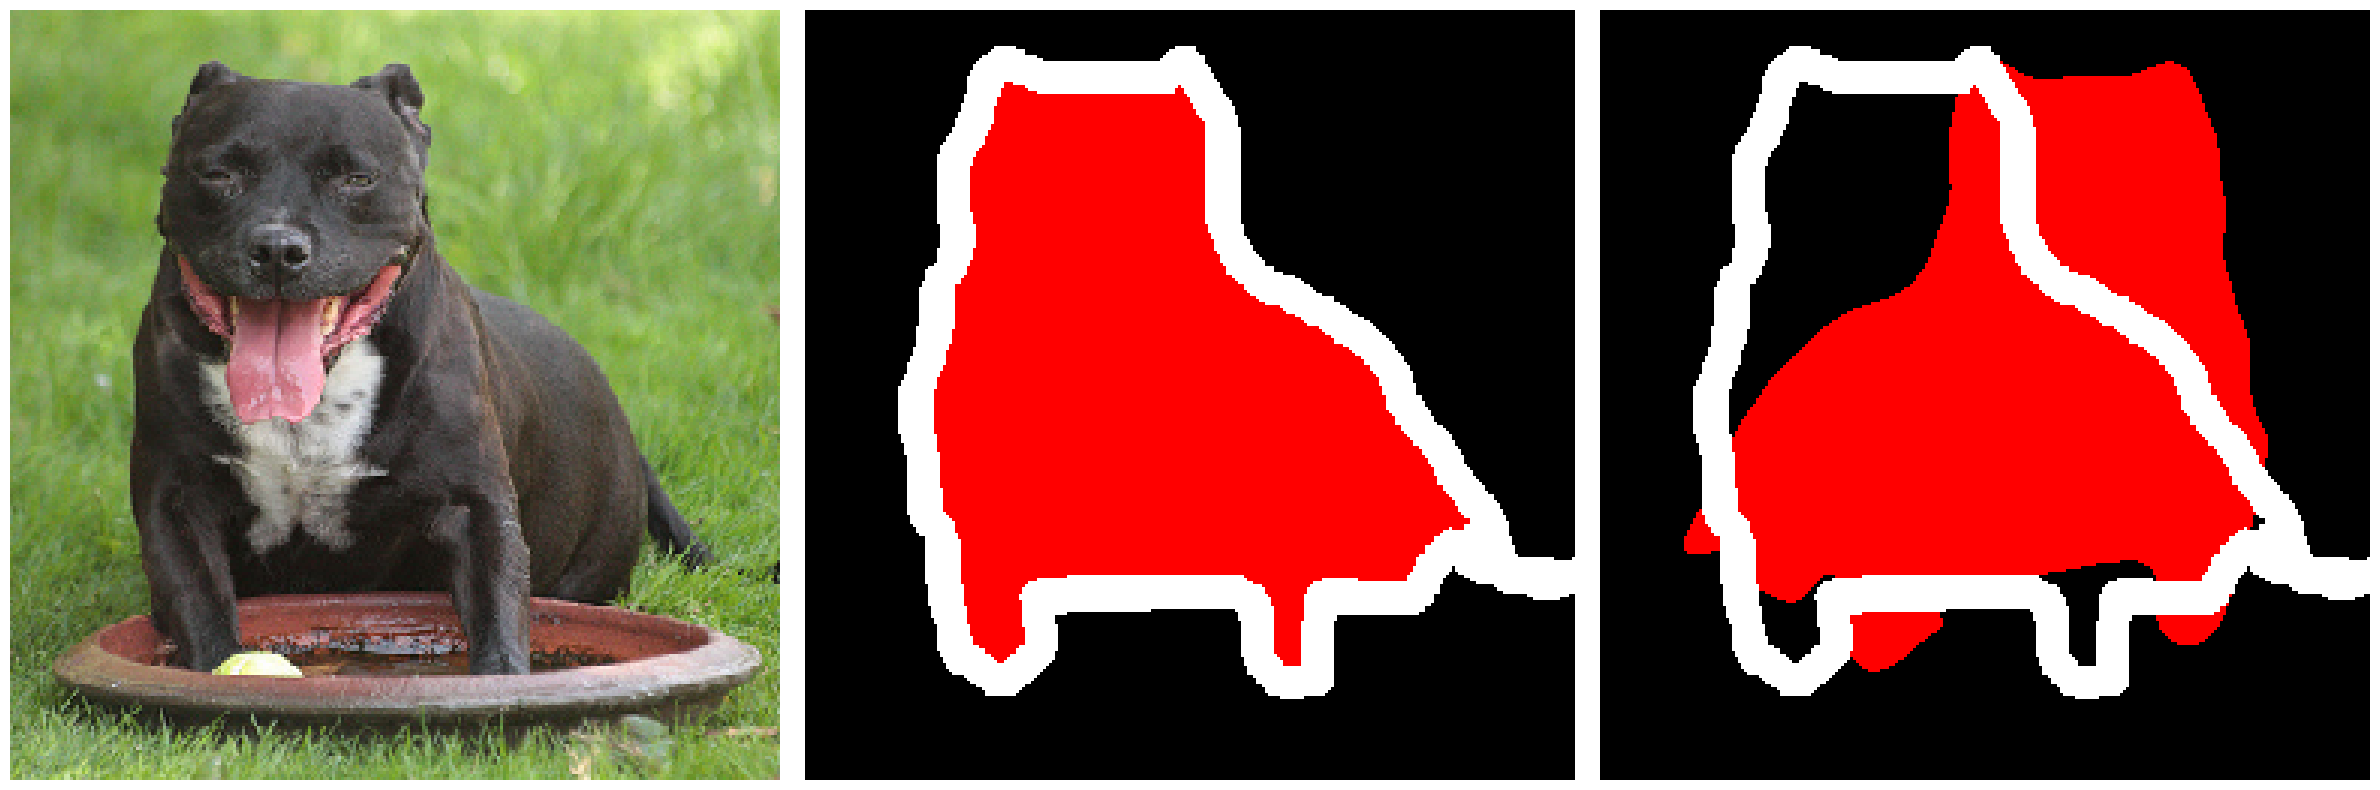

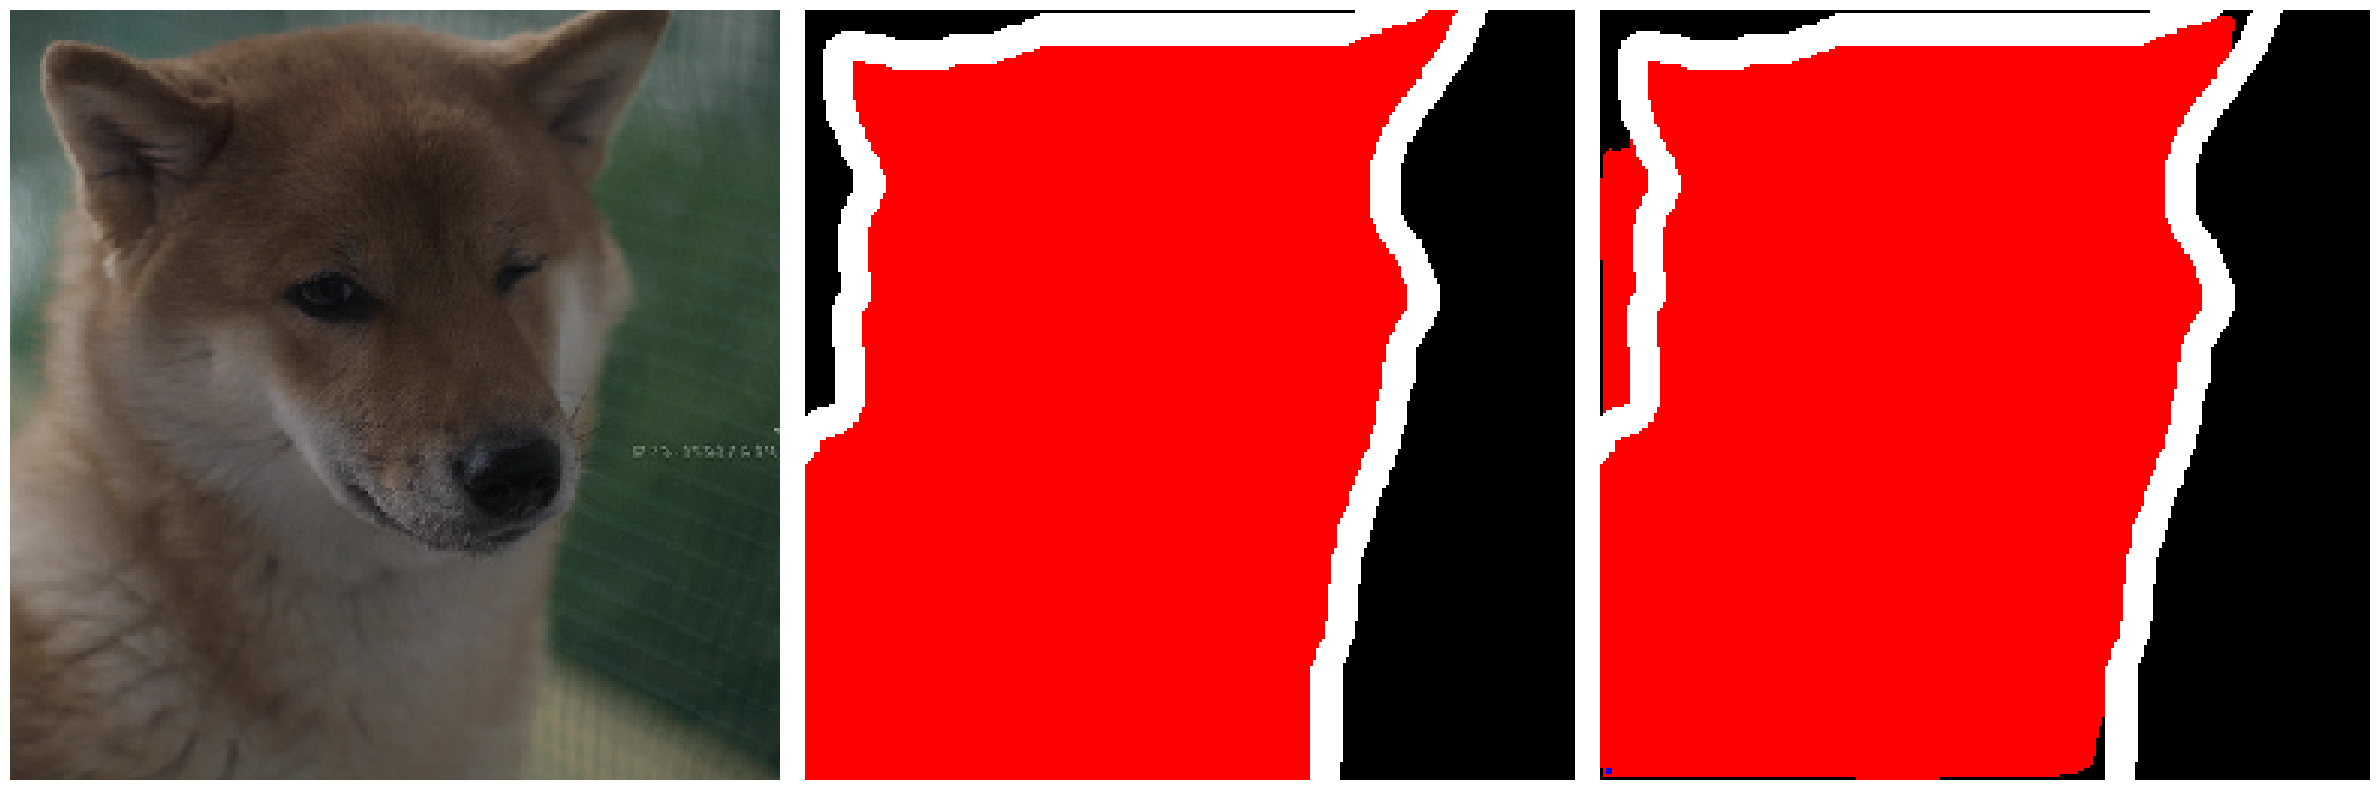

In [50]:
# Примеры работы вами сети:
img_idx = np.random.randint(0, 100)
for idx, (input, target) in enumerate(test_dataloader):
    if (idx < img_idx):
        continue
    draw((input[0].squeeze(), target[0].squeeze()), t_dict, dl_prediction[idx * 16])
    plt.pause(0.1)
    if (idx == img_idx+2):
        break

**FocalLoss**

In [51]:
from torch.optim.lr_scheduler import StepLR

train_config = {
    "num_epochs": 2, # примерное время обучения ~ 20 минут на GPU
    "optimizer": torch.optim.Adam,
    "optimizer_params": {
        "lr": 1e-3,
        "weight_decay": 1e-5
    },
    "loss_fn": metric_class.FocalLoss,
    "scheduler": StepLR,
    "scheduler_params": {
        "step_size": 50,
        "gamma": 0.85
    },
    "validate_each_iter": 10,
    "writer": SummaryWriter(comment="Floss"),
    "save_model_path": "model_floss",
    "metric_class": metric_class
}

net = PSPNet(pretrained_model, SegmentationHead, num_classes=3, train_config=train_config).to(DEVICE)
print("#параметров в сети:", count_parameters(net))

Pretrained main module conv1 is loaded
Pretrained main module bn1 is loaded
Pretrained main module relu is loaded
Pretrained main module maxpool is loaded
Pretrained main module layer1 is loaded
Pretrained main module layer2 is loaded
Pretrained supp module layer3 is loaded
Pretrained supp module layer4 is loaded
#параметров в сети: 31107843


In [52]:
net.train_model(train_dataloader, val_dataloader)

Epoch: 1/2 || Iter: 0/184 || Loss: 0.9089447259902954
Epoch: 1/2 || Iter: 10/184 || Loss: 0.2779631018638611
Epoch: 1/2 || Iter: 20/184 || Loss: 0.14239181578159332
Epoch: 1/2 || Iter: 30/184 || Loss: 0.202052503824234
Epoch: 1/2 || Iter: 40/184 || Loss: 0.11015700548887253
Epoch: 1/2 || Iter: 50/184 || Loss: 0.2503516972064972
Epoch: 1/2 || Iter: 60/184 || Loss: 0.10800569504499435
Epoch: 1/2 || Iter: 70/184 || Loss: 0.16200360655784607
Epoch: 1/2 || Iter: 80/184 || Loss: 0.099774070084095
Epoch: 1/2 || Iter: 90/184 || Loss: 0.19427837431430817
Epoch: 1/2 || Iter: 100/184 || Loss: 0.13082408905029297
Epoch: 1/2 || Iter: 110/184 || Loss: 0.1130128875374794
Epoch: 1/2 || Iter: 120/184 || Loss: 0.19828611612319946
Epoch: 1/2 || Iter: 130/184 || Loss: 0.07970017194747925
Epoch: 1/2 || Iter: 140/184 || Loss: 0.16809920966625214
Epoch: 1/2 || Iter: 150/184 || Loss: 0.09174887090921402
Epoch: 1/2 || Iter: 160/184 || Loss: 0.08256665617227554
Epoch: 1/2 || Iter: 170/184 || Loss: 0.07692269980

In [54]:
# Протестируйте вторую модель и сравните метрики:
net.load_state_dict(torch.load("model_floss_2.pth"))  # Не забудьте поменять версию `_1`-> `_n` если запускаете несколько раз!
net.eval();
dl_prediction, dl_target = net.test_model(test_dataloader)
print("Mean IoU metric: ", metric_class.IoUMetric(dl_prediction, dl_target))
print("Mean Recall metric: ", metric_class.RecallMetric(dl_prediction, dl_target))

/tmp/ipykernel_3393024/4074497838.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("model_floss_2.pth"))  # Не забудьте поменять версию `_1

Mean IoU metric:  tensor(0.9071)
Mean Recall metric:  tensor(0.9477)


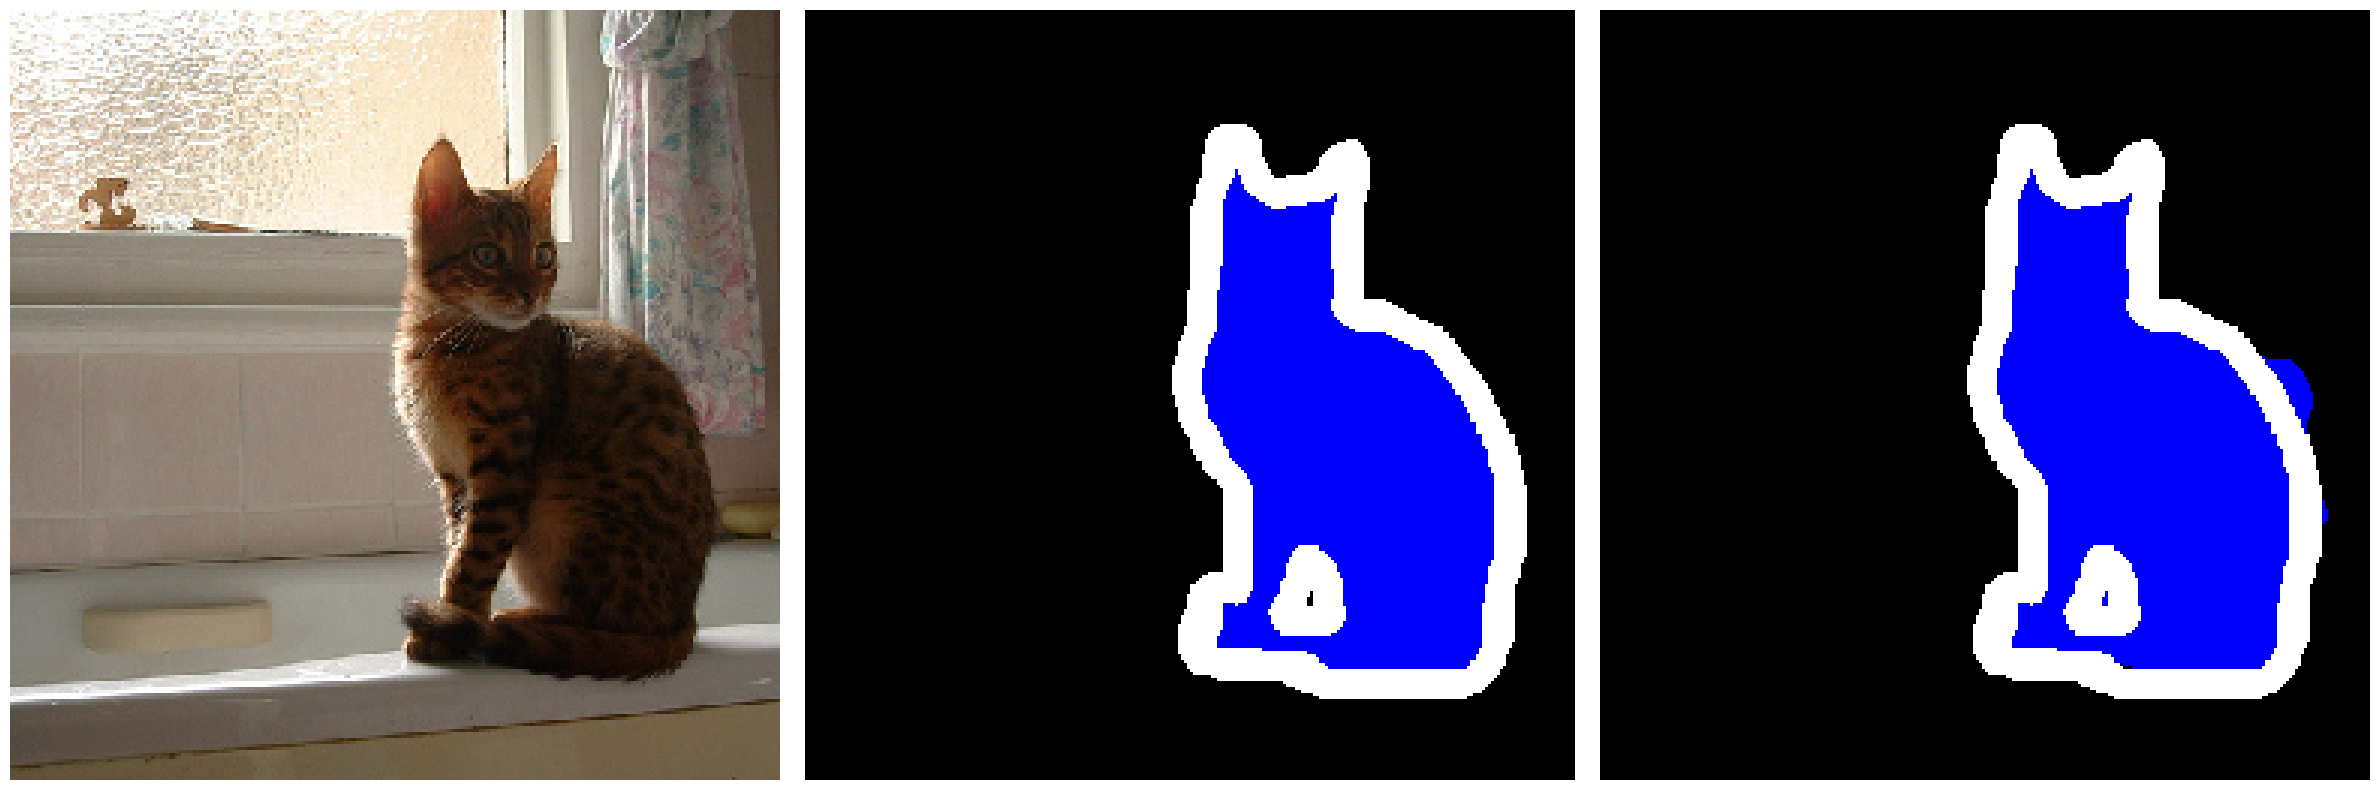

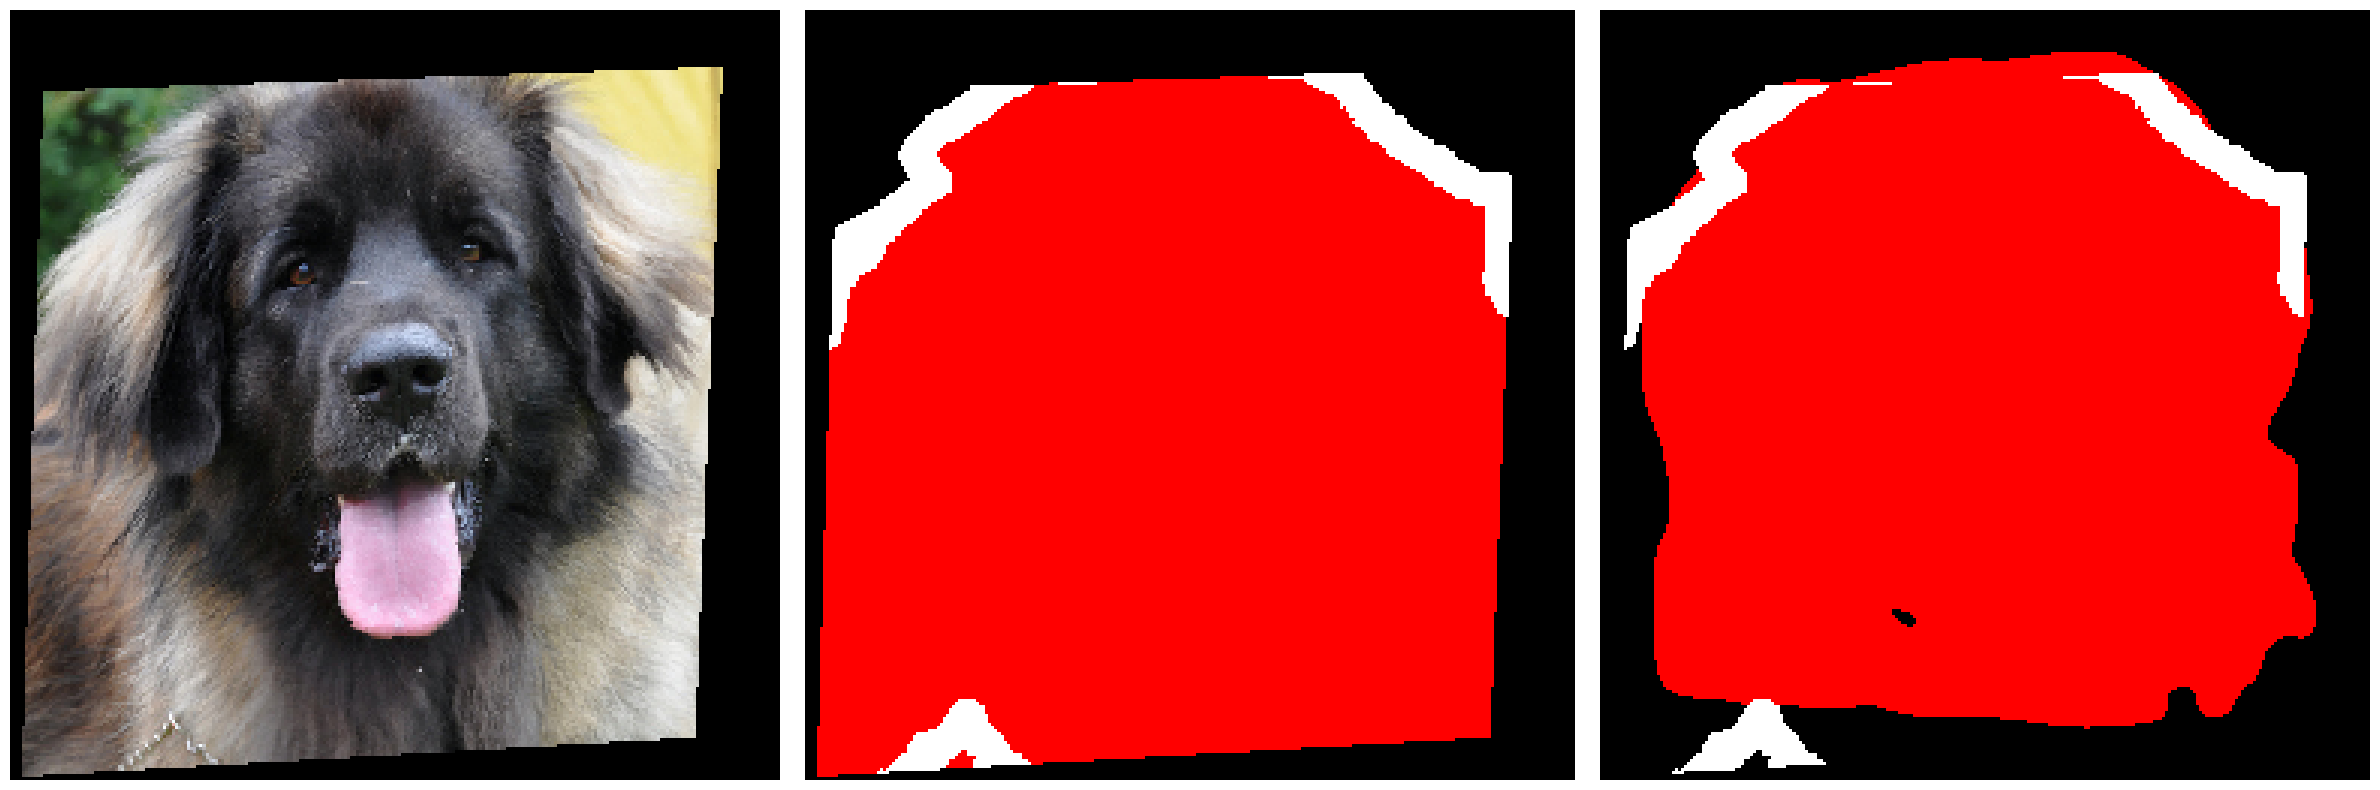

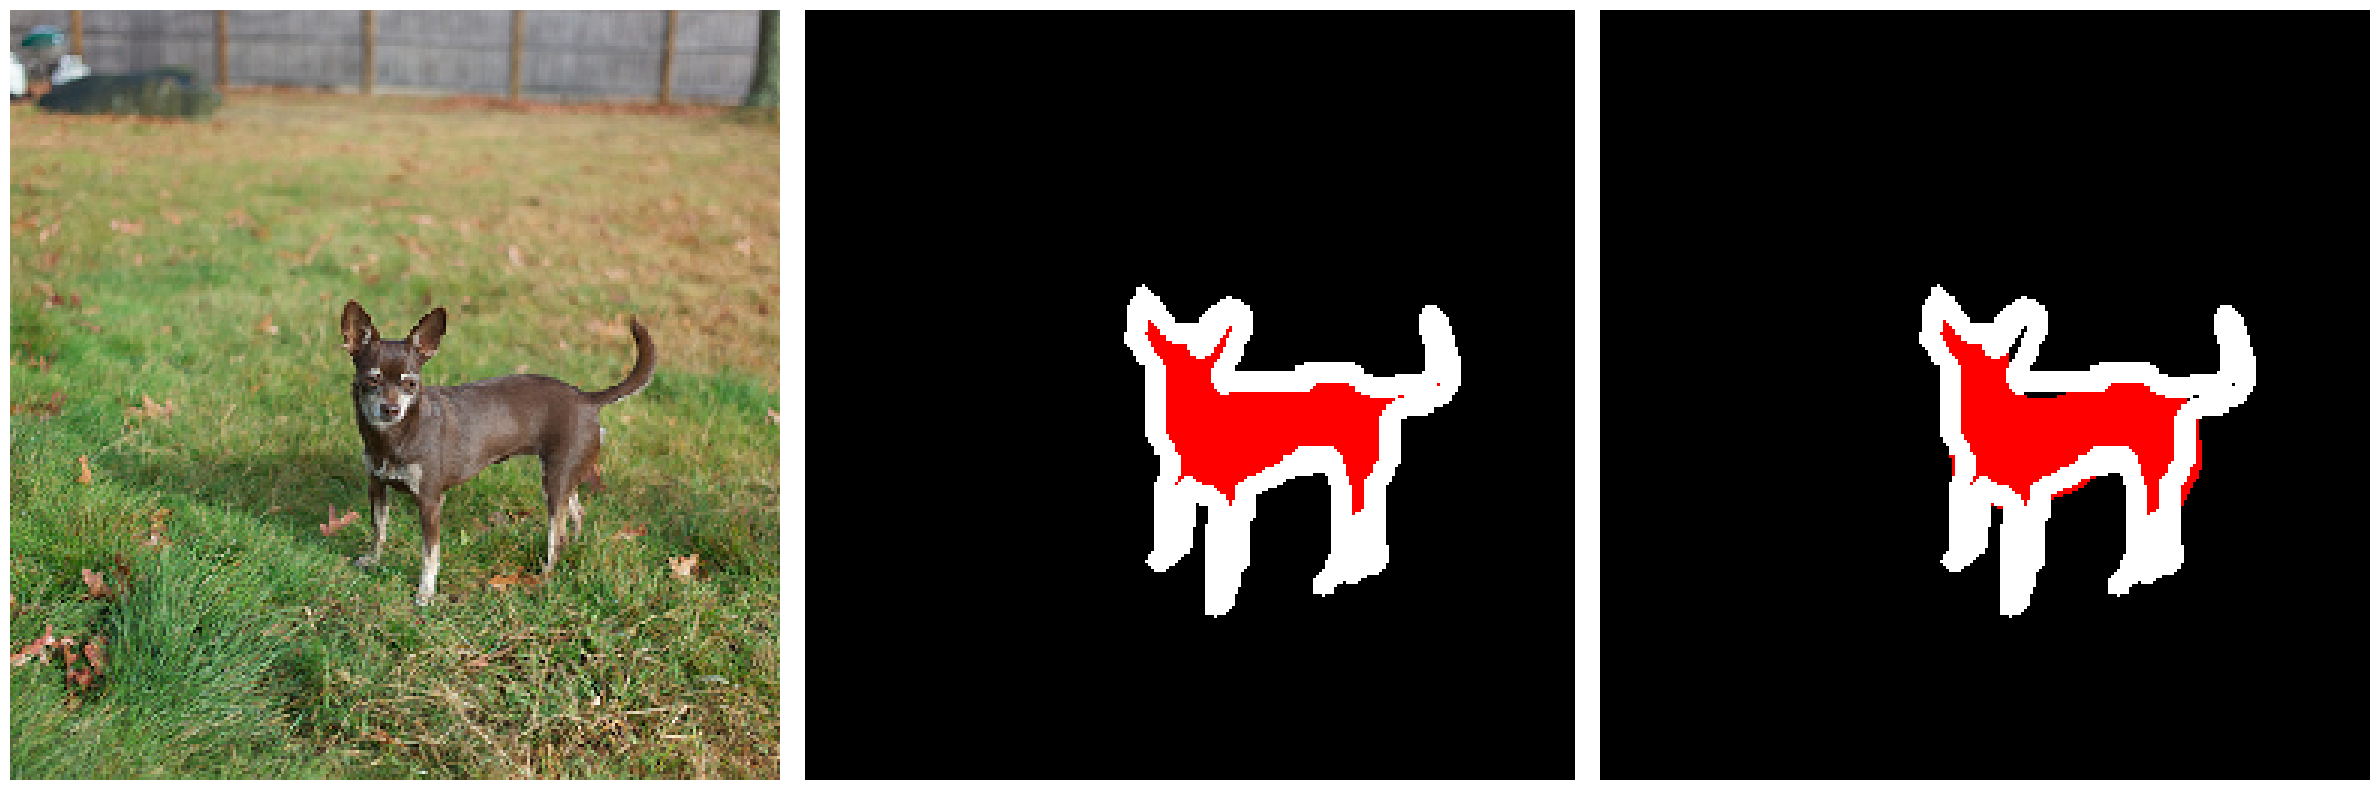

In [57]:
# Примеры работы вами сети:
img_idx = np.random.randint(0, 100)
for idx, (input, target) in enumerate(test_dataloader):
    if (idx < img_idx):
        continue
    draw((input[0].squeeze(), target[0].squeeze()), t_dict, dl_prediction[idx * 16])
    plt.pause(0.1)
    if (idx == img_idx+2):
        break

In [59]:
!tensorboard upload --logdir runs \
--name "My latest experiment" \
--description "Simple comparison of several hyperparameters"

2024-10-24 21:59:10.695868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 21:59:10.712732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 21:59:10.717910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 21:59:10.729561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 21:59:11.734852: W tensorflow/compiler/tf2

In [62]:
%reload_ext tensorboard
%tensorboard --logdir ./runs

Reusing TensorBoard on port 6010 (pid 3401828), started 0:00:27 ago. (Use '!kill 3401828' to kill it.)

In [63]:
!zip -r 'runs.zip' 'runs'

  adding: runs/ (stored 0%)
  adding: runs/Oct24_20-18-54_4f9df2fc2b3fFloss/ (stored 0%)
  adding: runs/Oct24_20-18-54_4f9df2fc2b3fFloss/events.out.tfevents.1729790334.4f9df2fc2b3f.3393024.2 (deflated 6%)
  adding: runs/Oct24_19-48-16_4f9df2fc2b3fCEloss/ (stored 0%)
  adding: runs/Oct24_19-48-16_4f9df2fc2b3fCEloss/events.out.tfevents.1729788496.4f9df2fc2b3f.3393024.1 (deflated 6%)
